### Import Dependencies

In [1]:
# Import dependecies
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPool2D, Dropout, 
                                     BatchNormalization, UpSampling2D, 
                                     Concatenate)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
import cv2

### Create UNet Model

In [2]:
# define parameters
img_size = 256
filters_list = [64, 128, 256, 512]

# initialization 
encoding_layers = []
block_idx = 0


# input layer
ip = Input(shape=(img_size, img_size, 1), name='Input')
x = ip


for i, filters in enumerate(filters_list):
    #1st convolution
    x = Conv2D(filters, (3,3),
               padding='same', 
               activation=None,
               kernel_initializer='he_normal',
               name='E_Block%i_Conv1'%block_idx)(x)  # E_Block0_Conv1
    
    x = BatchNormalization(name='E_Block%i_BN1'%block_idx)(x)
    x = tf.nn.relu(x)
    x = Dropout(0.5, name='E_Block%i_Drop1'%block_idx)(x)
    
    
    #2nd convolution  
    x = Conv2D(filters, (3,3), padding='same', activation=None, 
               kernel_initializer='he_normal', 
               name='E_Block%i_Conv2'%block_idx)(x)
    x = BatchNormalization(name='E_Block%i_BN2'%block_idx)(x)
    x = tf.nn.relu(x)
    x = Dropout(0.5, name='E_Block%i_Drop2'%block_idx)(x) 
    
    encoding_layers.append(x)
    # maxpooling 
    x = MaxPool2D(name='E_Block%i_MaxPool'%block_idx)(x)
    block_idx += 1  # increase the id of block ie. block0, block 1, etc
    


# filters_list[-1] = 512   the last index
# 512 *2 =  1024

x = Conv2D(filters_list[-1]*2, (3,3), padding='same', 
           activation=None, kernel_initializer='he_normal', 
           name='E_Block%i_Conv1'%block_idx)(x)
x = BatchNormalization(name='E_Block%i_BN1'%block_idx)(x)
x = tf.nn.relu(x)
x = Dropout(0.5, name='E_Block%i_Drop1'%block_idx)(x)


x = Conv2D(filters_list[-1]*2, (3,3), padding='same', activation=None, kernel_initializer='he_normal', name='E_Block%i_Conv2'%block_idx)(x)
x = BatchNormalization(name='E_Block%i_BN2'%block_idx)(x)
x = tf.nn.relu(x)
x = Dropout(0.5, name='E_Block%i_Drop2'%block_idx)(x)


encoding_layers.reverse()  # to concatenate

# Decoding path
filters_list.reverse()

for i, filters in enumerate(filters_list):
    x = UpSampling2D(size=(2,2), name='D_Block%i_UpSamp'%block_idx)(x)
    block_idx += 1
    x = Concatenate(name='D_Block%i_Skip'%block_idx)([x, encoding_layers[i]])  # encoding_layers are already reversed
    
    
    x = Conv2D(filters, (3,3), padding='same', activation=None,kernel_initializer='he_normal', name='D_Block%i_Conv1'%block_idx)(x)
    x = tf.nn.relu(x)
    x = Dropout(0.5, name='E_Block%i_Drop1'%block_idx)(x)
    
    
    x = Conv2D(filters, (3,3), padding='same', activation=None,kernel_initializer='he_normal', name='D_Block%i_Conv2'%block_idx)(x)
    x = tf.nn.relu(x)
    x = Dropout(0.5, name='E_Block%i_Drop2'%block_idx)(x)

# final output layer
# binary classification so class=1 and used sigmoid

op = Conv2D(1, (1,1), activation='sigmoid', name='Output')(x)

model = Model(inputs=ip, outputs=op, name='Unet')
model.summary()


Model: "Unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
E_Block0_Conv1 (Conv2D)         (None, 256, 256, 64) 640         Input[0][0]                      
__________________________________________________________________________________________________
E_Block0_BN1 (BatchNormalizatio (None, 256, 256, 64) 256         E_Block0_Conv1[0][0]             
__________________________________________________________________________________________________
tf.nn.relu (TFOpLambda)         (None, 256, 256, 64) 0           E_Block0_BN1[0][0]               
_______________________________________________________________________________________________

### Prepare the data

In [3]:
# Prepare data generators
seed = 0
batch_size = 32
img_size = 256
 
train_img_dir = 'lung_ct/train_images'
train_msk_dir = 'lung_ct/train_masks'
test_img_dir = 'lung_ct/test_images'
test_msk_dir = 'lung_ct/test_masks'
 
imgDataGenTrain = ImageDataGenerator( rescale=1/255,
                                      data_format = "channels_last",
                                      rotation_range = 180,
                                      width_shift_range = 0.15,
                                      height_shift_range = 0.15,
                                      shear_range = 0.2,
                                      zoom_range = 0.2,
                                      fill_mode = 'constant',
                                      cval = 0.0,
                                      horizontal_flip = True,
                                      vertical_flip = True)
 
maskDataGenTrain = ImageDataGenerator(rescale=1/1,
                                      data_format = "channels_last",
                                      rotation_range = 180,
                                      width_shift_range = 0.15,
                                      height_shift_range = 0.15,
                                      shear_range = 0.2,
                                      zoom_range = 0.2,
                                      fill_mode = 'constant',
                                      cval = 0.0,
                                      horizontal_flip = True,
                                      vertical_flip = True,
                                      preprocessing_function = lambda x: np.where(x > 127, 1, 0).astype(x.dtype))

trainImgGenerator = imgDataGenTrain.flow_from_directory(train_img_dir,
                                                   target_size=(img_size,img_size),
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   color_mode='grayscale',
                                                   class_mode=None,
                                                   seed=seed)
 
trainMskGenerator = maskDataGenTrain.flow_from_directory(train_msk_dir,
                                                    target_size=(img_size,img_size),
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    color_mode='grayscale',
                                                    class_mode=None,
                                                    seed=seed)

imgDataGenTest = ImageDataGenerator(rescale=1/255,
                                data_format ="channels_last")
 
maskDataGenTest = ImageDataGenerator(rescale=1/1,
                                 data_format ="channels_last",
                                 preprocessing_function = lambda x: np.where(x>127, 1, 0).astype(x.dtype))

testImgGenerator = imgDataGenTest.flow_from_directory( test_img_dir,
                                                   target_size=(img_size,img_size),
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   color_mode='grayscale',
                                                   class_mode=None,
                                                   seed=seed)
 
testMskGenerator = maskDataGenTest.flow_from_directory( test_msk_dir,
                                                    target_size=(img_size,img_size),
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    color_mode='grayscale',
                                                    class_mode=None,
                                                    seed=seed)

# Zip together image (x) and mask (y) data generators 
trainGenerator = zip(trainImgGenerator, trainMskGenerator)
testGenerator = zip(testImgGenerator, testMskGenerator)

Found 3282 images belonging to 1 classes.
Found 3282 images belonging to 1 classes.
Found 1990 images belonging to 1 classes.
Found 1990 images belonging to 1 classes.


### Checking the shapes of the input data

In [4]:
# Check data
train_images = trainImgGenerator.__getitem__(0)
train_masks = trainMskGenerator.__getitem__(0)

test_images = testImgGenerator.__getitem__(0)
test_masks = testMskGenerator.__getitem__(0)

print(train_images.shape)
print(train_masks.shape)

(32, 256, 256, 1)
(32, 256, 256, 1)


### Visualize some input data

In [5]:
# Write a function for plotting contours on images
def draw_contours(x, y_true, y_pred=None, pred=False):
  image = cv2.merge([x, x, x])
  image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
  contours = cv2.findContours(y_true.astype('uint8'), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
  image = cv2.drawContours(image, contours, -1, [0,255,0], 1)
  if pred:
    contours = cv2.findContours(y_pred.astype('uint8'), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    image = cv2.drawContours(image, contours, -1, [255,0,0], 1)
  return image

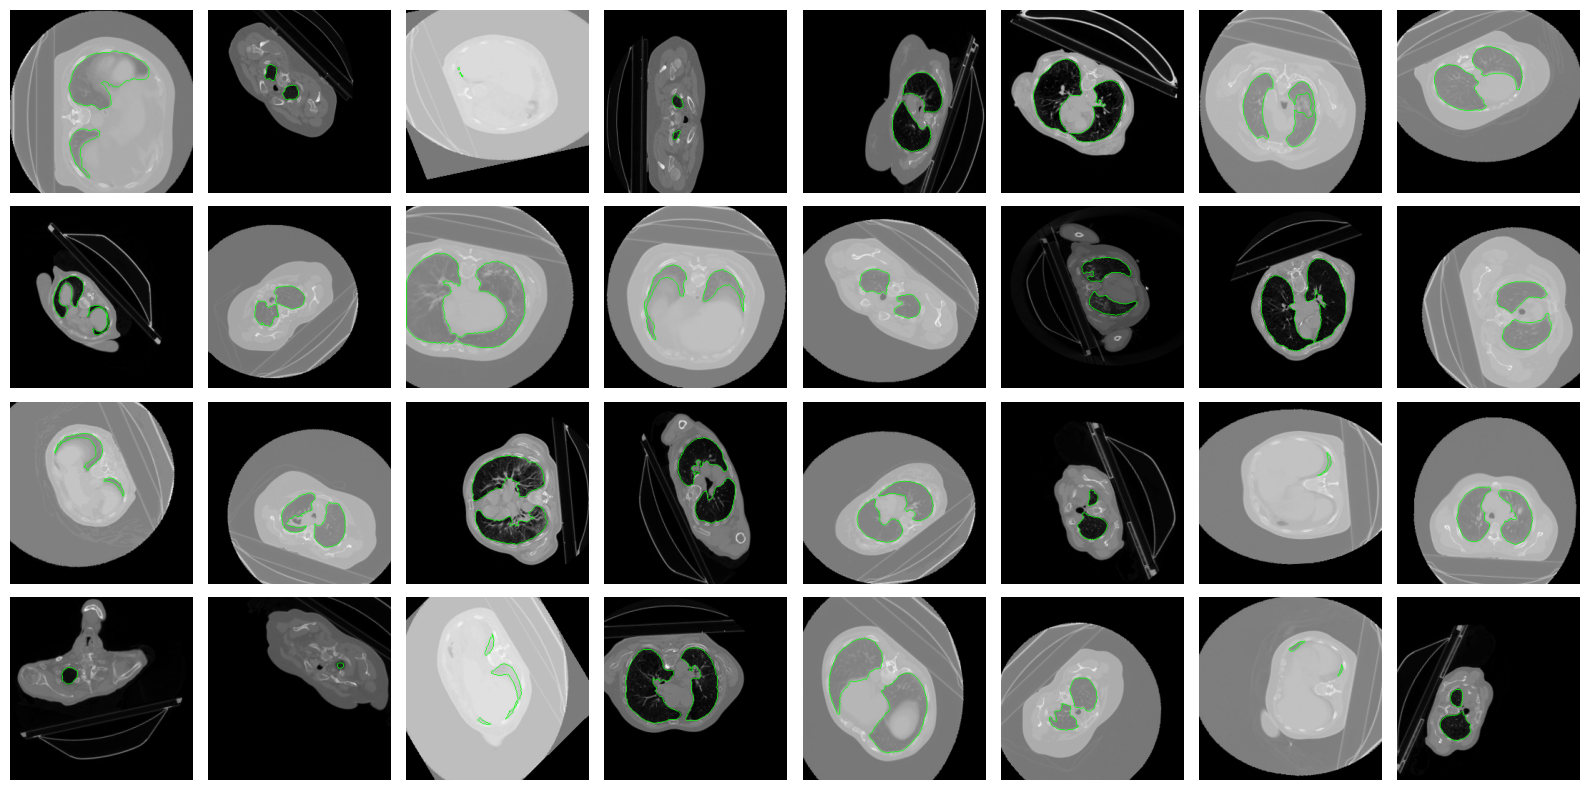

In [6]:
# Display some of the traning images with contours
plt.figure(figsize=(16,8))
for i in range(32):
  plt.subplot(4,8,i+1)
  cont_image = draw_contours(train_images[i,:,:,0], train_masks[i,:,:,0])
  plt.imshow(cont_image)
  plt.axis('off')
plt.tight_layout()
plt.show()

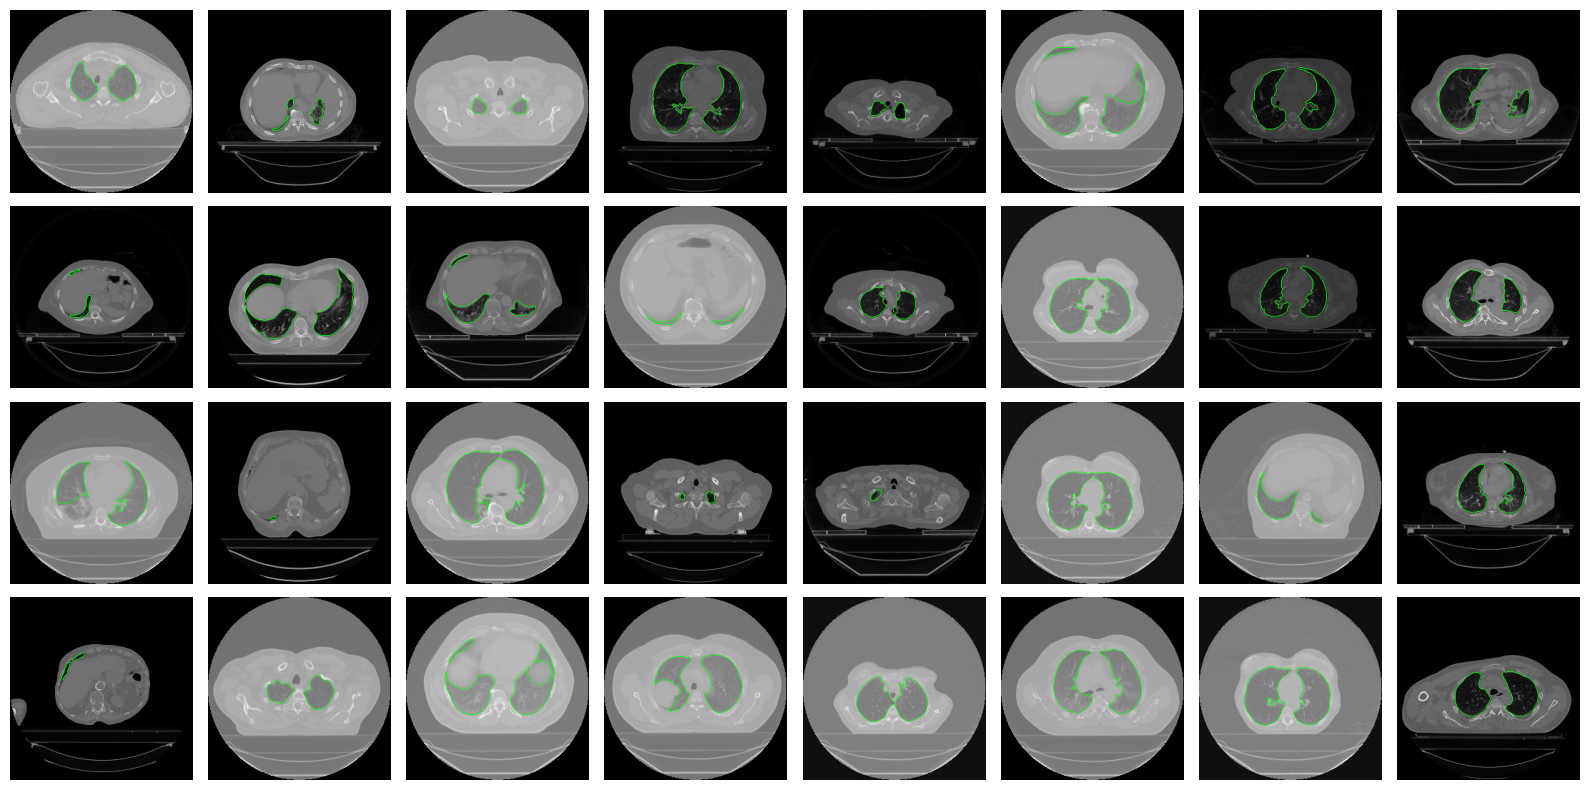

In [7]:
# Display some of the test images with contours
plt.figure(figsize=(16,8))
for i in range(32):
  plt.subplot(4,8,i+1)
  cont_image = draw_contours(test_images[i,:,:,0], test_masks[i,:,:,0])
  plt.imshow(cont_image)
  plt.axis('off')
plt.tight_layout()
plt.show()

###  Compile the model (For compile we need to create the Dice Loss function)

In [8]:
# Dice coefficient metric and loss functions
# smooth to avoid division by zero when both y_pred and y_true do not contain any foreground pixels

def dice(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_loss(y_true, y_pred):
    return 1 - dice(y_true, y_pred)

In [9]:
model.compile(optimizer='adam', loss= dice_loss, metrics=['accuracy', dice])

### Train the Model

In [ ]:
# Train model
# Early stopping callback
early_stop = EarlyStopping(monitor='val_dice', min_delta=0, patience=10,
                           verbose=0, mode='max', baseline=None, 
                           restore_best_weights=True)
epochs = 100
 
history = model.fit(trainGenerator,
                    epochs = epochs,
                    steps_per_epoch = (3282//32),
                    validation_data = testGenerator,
                    validation_steps = (1990//32),
                    verbose = 1,
                    callbacks = [early_stop])

Epoch 1/100
